# Reg GAN

In [ ]:
!python -m pip install https://github.com/tslearn-team/tslearn/archive/main.zip

     \ 3.0 MB 67.5 kB/s 0:00:440m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 64.6 kB/s eta 0:00:00m eta 0:00:010:00:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 71.7 kB/s eta 0:00:00m eta 0:00:010:00:09
  Created wheel for tslearn: filename=tslearn-0.5.2-cp39-cp39-macosx_11_0_arm64.whl size=355516 sha256=c223572ca1196d42ee744694997fa614b4790f03e0f2544213482e388fd93502
  Stored in directory: /private/var/folders/4j/8mx5dnzd1p34_5y5r19b4g5m0000gn/T/pip-ephem-wheel-cache-dbbquv6t/wheels/46/ae/76/45bf2e989e5ef22b76c70e43c48a587f36d02d63c8ded68a12
Successfully built tslearn


In [ ]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
from datetime import datetime
# Move to GeomPrior/aria `pip install -e ./`
import aria 
from aria.components.dataframe_regressor import DataFrameRegressor
from aria.components.fourier_seasonality import FourierSeasonality
from aria.components.linear_trend import LinearTrend
from aria.components.linear_trend_changepoints import LinearTrendChangepoints
from aria.datasets.example import load_data
from aria.models.forward_stepwise_selector import ForwardStepwiseSelector
from aria.models.linear_lasso import LinearLassoModel
from aria.models.linear_ridge import LinearRidgeModel
from aria.utils.evaluation import smape, bic
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from tslearn import metrics 
#!python -m pip install cython
#!conda config --set channel_priority false
#!python -m pip install https://github.com/tslearn-team/tslearn/archive/main.zip
#conda install -c conda-forge lxm
numpy.random.seed(0)

In [6]:
def download_prices_from_yf(ticker, start_date, end_date, label_list):
    yf.pdr_override()
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    return pdr.get_data_yahoo(ticker, start_date, end_date)[label_list]

## Real data

In [7]:
sp500 = download_prices_from_yf(start_date='2009-05-01', end_date='2021-01-01',
              ticker='^GSPC', label_list=['Adj Close'])
real_close = sp500['Adj Close']
real_return = np.log(real_close).diff().dropna()
real_mean = real_return.mean()
real_std = real_return.std()
standard_return = (real_return-real_mean)/real_std
sequence_data = np.asarray(standard_return) 

scaled_sp500_diff = sp500.rename(columns = {"Date":"ds", "Adj Close": "y"}).iloc[1:, :]
scaled_sp500_diff.reset_index(inplace = True)
scaled_sp500_diff.rename(columns = {"Date":"ds", "y":"y"}, inplace = True)
scaled_sp500_diff['y'] = sequence_data
df = scaled_sp500_diff

[*********************100%***********************]  1 of 1 completed


## TS decomposition

In [11]:
n = int(df.shape[0] * 0.8)
train_df, test_df = df.iloc[:n], df.iloc[n:]

components = [
    LinearTrend(),
    LinearTrendChangepoints(),
    FourierSeasonality(7, 3),
    FourierSeasonality(30.4375, 5),
    FourierSeasonality(365.25, 10),
]

components2 = [
    LinearTrend(),
    FourierSeasonality(7, 3),
    FourierSeasonality(30.4375, 5),
    FourierSeasonality(365.25, 10),
]
print('RIDGE') 
m = LinearRidgeModel(components=components) 
m.fit(train_df)
#print(pd.DataFrame(index=m1.get_features_list(), data=m1.get_params()))
print('SMAPE', smape(test_df['y'], m.predict(test_df)['yhat']))

print('Lasso') 
m1 = LinearLassoModel(components=components)
m1.fit(train_df)
#print(pd.DataFrame(index=m2.get_features_list(), data=m2.get_params()))
print('SMAPE', smape(test_df['y'], m1.predict(test_df)['yhat']))

print('w.o.trendchangpoint') 
m2 = LinearRidgeModel(components=components2)
m2.fit(train_df)
#print(pd.DataFrame(index=m2.get_features_list(), data=m2.get_params()))
print('SMAPE', smape(test_df['y'], m2.predict(test_df)['yhat']))

RIDGE
SMAPE 1.7181945029369528
Lasso
SMAPE 2.0
w.o.trendchangpoint
SMAPE 1.7246242378411143


- Ridge (normal prior) has a lower SMAPE (1.71 vs 1.77) than Lasso.
- With changepoints has a lower SMAPE (1.718 vs 1.724) than without.

array([[<AxesSubplot:title={'center':'coef'}>]], dtype=object)

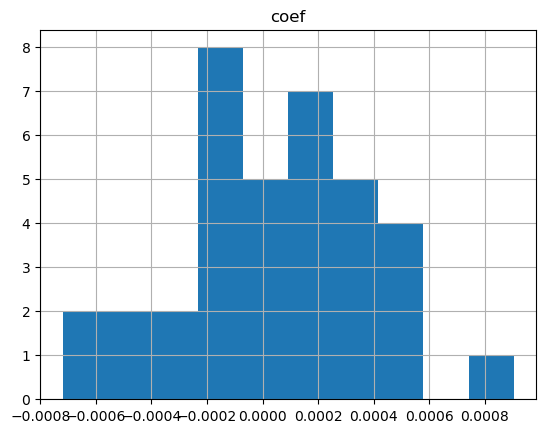

In [40]:
m_coef = pd.DataFrame({"feature": m.get_features_list(), "coef": m.get_params()})
season_coef = m_coef[m_coef.feature.str.contains('FS')]
season_coef.hist()


## Will be doing (after 08/19): TS clustering

In [41]:
!conda install ists

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - ists

Current channels:

  - https://repo.anaconda.com/pkgs/main/osx-arm64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/osx-arm64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [ ]:
s_x = numpy.array(
    [-0.790, -0.765, -0.734, -0.700, -0.668, -0.639, -0.612, -0.587, -0.564,
     -0.544, -0.529, -0.518, -0.509, -0.502, -0.494, -0.488, -0.482, -0.475,
     -0.472, -0.470, -0.465, -0.464, -0.461, -0.458, -0.459, -0.460, -0.459,
     -0.458, -0.448, -0.431, -0.408, -0.375, -0.333, -0.277, -0.196, -0.090,
     0.047, 0.220, 0.426, 0.671, 0.962, 1.300, 1.683, 2.096, 2.510, 2.895,
     3.219, 3.463, 3.621, 3.700, 3.713, 3.677, 3.606, 3.510, 3.400, 3.280,
     3.158, 3.038, 2.919, 2.801, 2.676, 2.538, 2.382, 2.206, 2.016, 1.821,
     1.627, 1.439, 1.260, 1.085, 0.917, 0.758, 0.608, 0.476, 0.361, 0.259,
     0.173, 0.096, 0.027, -0.032, -0.087, -0.137, -0.179, -0.221, -0.260,
     -0.293, -0.328, -0.359, -0.385, -0.413, -0.437, -0.458, -0.480, -0.498,
     -0.512, -0.526, -0.536, -0.544, -0.552, -0.556, -0.561, -0.565, -0.568,
     -0.570, -0.570, -0.566, -0.560, -0.549, -0.532, -0.510, -0.480, -0.443,
     -0.402, -0.357, -0.308, -0.256, -0.200, -0.139, -0.073, -0.003, 0.066,
     0.131, 0.186, 0.229, 0.259, 0.276, 0.280, 0.272, 0.256, 0.234, 0.209,
     0.186, 0.162, 0.139, 0.112, 0.081, 0.046, 0.008, -0.032, -0.071, -0.110,
     -0.147, -0.180, -0.210, -0.235, -0.256, -0.275, -0.292, -0.307, -0.320,
     -0.332, -0.344, -0.355, -0.363, -0.367, -0.364, -0.351, -0.330, -0.299,
     -0.260, -0.217, -0.172, -0.128, -0.091, -0.060, -0.036, -0.022, -0.016,
     -0.020, -0.037, -0.065, -0.104, -0.151, -0.201, -0.253, -0.302, -0.347,
     -0.388, -0.426, -0.460, -0.491, -0.517, -0.539, -0.558, -0.575, -0.588,
     -0.600, -0.606, -0.607, -0.604, -0.598, -0.589, -0.577, -0.558, -0.531,
     -0.496, -0.454, -0.410, -0.364, -0.318, -0.276, -0.237, -0.203, -0.176,
     -0.157, -0.145, -0.142, -0.145, -0.154, -0.168, -0.185, -0.206, -0.230,
     -0.256, -0.286, -0.318, -0.351, -0.383, -0.414, -0.442, -0.467, -0.489,
     -0.508, -0.523, -0.535, -0.544, -0.552, -0.557, -0.560, -0.560, -0.557,
     -0.551, -0.542, -0.531, -0.519, -0.507, -0.494, -0.484, -0.476, -0.469,
     -0.463, -0.456, -0.449, -0.442, -0.435, -0.431, -0.429, -0.430, -0.435,
     -0.442, -0.452, -0.465, -0.479, -0.493, -0.506, -0.517, -0.526, -0.535,
     -0.548, -0.567, -0.592, -0.622, -0.655, -0.690, -0.728, -0.764, -0.795,
     -0.815, -0.823, -0.821])

s_y1 = numpy.concatenate((s_x, s_x)).reshape((-1, 1))
s_y2 = numpy.concatenate((s_x, s_x[::-1])).reshape((-1, 1))
sz = s_y1.shape[0]

path, sim = metrics.dtw_path(s_y1, s_y2)

plt.figure(1, figsize=(8, 8))

# definitions for the axes
left, bottom = 0.01, 0.1
w_ts = h_ts = 0.2
left_h = left + w_ts + 0.02
width = height = 0.65
bottom_h = bottom + height + 0.02

rect_s_y = [left, bottom, w_ts, height]
rect_gram = [left_h, bottom, width, height]
rect_s_x = [left_h, bottom_h, width, h_ts]

ax_gram = plt.axes(rect_gram)
ax_s_x = plt.axes(rect_s_x)
ax_s_y = plt.axes(rect_s_y)

mat = cdist(s_y1, s_y2)

ax_gram.imshow(mat, origin='lower')
ax_gram.axis("off")
ax_gram.autoscale(False)
ax_gram.plot([j for (i, j) in path], [i for (i, j) in path], "w-",
             linewidth=3.)

ax_s_x.plot(numpy.arange(sz), s_y2, "b-", linewidth=3.)
ax_s_x.axis("off")
ax_s_x.set_xlim((0, sz - 1))

ax_s_y.plot(- s_y1, numpy.arange(sz), "b-", linewidth=3.)
ax_s_y.axis("off")
ax_s_y.set_ylim((0, sz - 1))

plt.tight_layout()
plt.show()

In [12]:
def train_step_raw(images, generator, discriminator, generator_optimizer, discriminator_optimizer, choice, pre_trained=None):
    noise = tf.random.normal((images.shape[0],) + generator.input_shape[1:])

    with tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      if choice == 'wgan_gp':
        disc_loss = discriminator_loss(real_output, fake_output, choice, generated_images = generated_images, images= images, discriminator=discriminator)
      else:
        disc_loss = discriminator_loss(real_output, fake_output, choice)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)   
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    noise = tf.random.normal((images.shape[0],) + generator.input_shape[1:])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output, choice)

      if pre_trained is not None: 
        pre_trained_output = pre_trained(generated_images, training=True) # 0 or 1 from D2
        gen_loss += generator_loss(pre_trained_output, choice)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)     
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return gen_loss, disc_loss

In [13]:
def train(dataset, batchsize, generator, discriminator, G_opt, D_opt, test, epochs, choice, pre_trained=None):
  train_step = tf.function(train_step_raw)
  dataset = dataset.astype('float32')
  image_batch = tf.Variable(initial_value=np.zeros((batchsize,)+dataset.shape[1:]), trainable=False, dtype='float32')
  datasize = dataset.shape[0]

  for epoch in range(epochs):
    start = time.time()

    G_list = []; D_list = []

    for i in range(datasize//batchsize):
      image_batch.assign(dataset[np.random.choice(datasize, size=batchsize, replace=False)])
      gen_loss, disc_loss = train_step(image_batch, generator, discriminator, G_opt, D_opt, choice, pre_trained)
      G_list.append(gen_loss)
      D_list.append(disc_loss) 

    G_loss.append(np.mean(G_list))
    D_loss.append(np.mean(D_list))

    for fun, seed in test:
      fun(generator, epoch + 1, seed) 

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

## Quant GAN

In [15]:
# official

prelu_kwargs = {'alpha_initializer':tf.keras.initializers.Constant(value=0.25), 'shared_axes':[1,2]}

def TemporalBlock(x, skip, output_dim, hidden_dim_skip, kernel_size, dilation, num_inner_blocks=2, batch_norm=False, **kwargs):
    drop_left = num_inner_blocks * (kernel_size - 1) * dilation
    in_dim = x.shape[-1]

    x_0 = x

    for i in range(num_inner_blocks):
      init = tf.keras.initializers.RandomUniform(minval=-1/np.sqrt(x.shape[2]*kernel_size), maxval=1/np.sqrt(x.shape[2]*kernel_size))
      inits = {'kernel_initializer': init, 'bias_initializer': init}
      x = tfa.layers.SpectralNormalization(layers.Conv1D(output_dim, kernel_size, strides=1, 
                                                       padding='valid', dilation_rate=dilation, **inits, **kwargs))(x)
      x = layers.PReLU(**prelu_kwargs)(x) 
      if batch_norm:
        x = layers.BatchNormalization()(x)
    
    if in_dim != output_dim: 
      init = tf.keras.initializers.RandomUniform(minval=-1/np.sqrt(x_0.shape[2]*1), maxval=1/np.sqrt(x_0.shape[2]*1))
      inits = {'kernel_initializer': init, 'bias_initializer': init}
      x_0 = tfa.layers.SpectralNormalization(layers.Conv1D(output_dim, 1, strides=1, padding='same', **inits, **kwargs))(x_0) 
    
    x = x + x_0[:,drop_left:]
    init = tf.keras.initializers.RandomUniform(minval=-1/np.sqrt(x.shape[2]*1), maxval=1/np.sqrt(x.shape[2]*1))
    inits = {'kernel_initializer': init, 'bias_initializer': init}
    skip = skip + tfa.layers.SpectralNormalization(layers.Conv1D(hidden_dim_skip, 1, strides=1, padding='same', **inits, **kwargs))(x[:, -skip.shape[1]:])
    
    return layers.PReLU(**prelu_kwargs)(x), skip

def TCN(x, output_dim, hidden_dims, hidden_dim_skip=50, 
        kernel_size=2, num_inner_blocks=2, dilation_factor=2, batch_norm=False, **kwargs):
    drop_left =  sum(num_inner_blocks * (kernel_size - 1) * dilation_factor**min(i,6) for i in range(len(hidden_dims)))
    skip = tf.zeros([tf.shape(x)[0], x.shape[1] - drop_left, hidden_dim_skip])
    
    x, skip = TemporalBlock(x, skip, hidden_dims[0], hidden_dim_skip, 1, 1, num_inner_blocks=2, batch_norm=batch_norm, **kwargs)
    for i, h in enumerate(hidden_dims):
        x, skip = TemporalBlock(x, skip, h, hidden_dim_skip, kernel_size, dilation_factor**min(i,6), num_inner_blocks=2, batch_norm=batch_norm, **kwargs)
    
    y = layers.PReLU(**prelu_kwargs)(skip) 
    init = tf.keras.initializers.RandomUniform(minval=-1/np.sqrt(y.shape[2]*1), maxval=1/np.sqrt(y.shape[2]*1))
    inits = {'kernel_initializer': init, 'bias_initializer': init}
    y = tfa.layers.SpectralNormalization(layers.Conv1D(hidden_dim_skip, 1, strides=1, padding='same', **inits, **kwargs))(y) 
    y = layers.PReLU(**prelu_kwargs)(y) 
    y = tfa.layers.SpectralNormalization(layers.Conv1D(output_dim, 1, strides=1, padding='same', **inits, **kwargs))(y) 
    return y